In [81]:
import json
import sys, os
import glob
import logging
logging.getLogger().setLevel(logging.CRITICAL)

from requests import Session, Request
from datetime import datetime, date, time, timedelta, timezone
from posixpath import join as urljoin
import pandas as pd
import io
from blume import client, station, measurements
from blume.station import Station
from sensemapi import client as sense_client
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
graph_dir = "ressources/grapics/"

from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import pytz
cet = pytz.timezone('CET')

# set the graphs to show in the jupyter notebook
%matplotlib inline

# set seaborn style to white
#sns.set_style("white")

from IPython.display import display, HTML

In [2]:
logging.getLogger().setLevel(logging.INFO)

In [3]:
def load_data(phenomenon, interval):
    filename = "ressources/{}_Measurments_Berlin_{}.cvs".format(phenomenon, interval)
    try:
        data = pd.read_csv(filename, index_col=0, parse_dates=True)
        data.sort_index(inplace=True)
    except FileNotFoundError:
        logging.warning("Could not find File {}, Returning Empty Dataframe instead".format(filename))                
        data = pd.DataFrame()
    return data

In [4]:
def investigate_stats(df):
    total = df.shape[0]*df.shape[1]
    notnull = df.notnull().sum().sum()
    isnull = df.isnull().sum().sum()
    print("General Shape (Hours x Sensors) = {}".format(df.shape))
    print("Non-NaN Values = {} from {} equals {}%".format(notnull, total, round((notnull/total)*100)))
    print("NaN Values = {} from {} equals {}%".format(isnull, total, round((isnull/total)*100)))

In [5]:
def ind_sensor_lookup(df, precision=70):
    total = df.shape[0]
    threshold = (total/100)*precision
    good_sensors = (df.notnull().sum().sort_values(ascending=False) > 1000).sum()
    print("Sensors that measured more than {}% of the Time according to the Conditional Remove = {} from {}".format(precision, good_sensors, df.shape[1]))

## Konzept/Plan
1. Lade Daten und bereinige diese von eventuel übrig gebliebenen Fehlerhaften Columns/Rows
2. Kürze den Titel der PM10/Feuchte/Temperatur Titel auf den Uniqen SenseBox-Teil
3. Merge Join des Datensatzes auf Rows
4. Merge Join des Datensatzes auf Columns
5. Merge Join des Datensatzes auf jeden einzelnen Messwert
6. Setze Treshold für Temp/Feuchte und wende diesen auf PM10 Messwerte an
7. Untersuche das Ergebniss


Join Strategien der Datensätze:

1. PM10 x Temperatur
2. PM10 x Feuchte
3. PM10 x Temperatur x Feuchte

Threshold Strategien der Datensätze:

1. Untersuche welche Threshold Höhe welche Auswirkungen auf die Daten hat
2. Untersuche, wieviele Sensoren zuverlässig und genügend Messwerte für den Betrachtungszeitraum liefern
3. Setze Limit für die minimale Messabdeckung eines Sensors im Betrachtungszeitraum
4. Finalen Datensatz speichern

Load Datasets and drop possible duplicates immediately

In [6]:
df_osem_pm10 = load_data("PM10", "Hours")
df_osem_pm10 = df_osem_pm10.loc[~df_osem_pm10.index.duplicated(keep='first')]
df_osem_feuchte = load_data("rel. Luftfeuchte", "Hours")
df_osem_feuchte = df_osem_feuchte.loc[~df_osem_feuchte.index.duplicated(keep='first')]
df_osem_temp = load_data("Temperatur", "Hours")
df_osem_temp = df_osem_temp.loc[~df_osem_temp.index.duplicated(keep='first')]

In [7]:
ind_sensor_lookup(df_osem_pm10)
ind_sensor_lookup(df_osem_feuchte)
ind_sensor_lookup(df_osem_temp)

Sensors that measured more than 70% of the Time according to the Conditional Remove = 92 from 135
Sensors that measured more than 70% of the Time according to the Conditional Remove = 91 from 150
Sensors that measured more than 70% of the Time according to the Conditional Remove = 94 from 155


In [8]:
print("------ PM10 Stats ------")
investigate_stats(df_osem_pm10)
print("------ Feuchte Stats ------")
investigate_stats(df_osem_feuchte)
print("------ Temp Stats ------")
investigate_stats(df_osem_temp)

------ PM10 Stats ------
General Shape (Hours x Sensors) = (1656, 135)
Non-NaN Values = 152476 from 223560 equals 68.0%
NaN Values = 71084 from 223560 equals 32.0%
------ Feuchte Stats ------
General Shape (Hours x Sensors) = (1752, 150)
Non-NaN Values = 162912 from 262800 equals 62.0%
NaN Values = 99888 from 262800 equals 38.0%
------ Temp Stats ------
General Shape (Hours x Sensors) = (1752, 155)
Non-NaN Values = 167729 from 271560 equals 62.0%
NaN Values = 103831 from 271560 equals 38.0%


Kürze den Header aller Sensor-DF auf den Uniqen SenseBox Part

In [9]:
df_osem_pm10.columns = df_osem_pm10.columns.map(lambda x: x[:22])
df_osem_feuchte.columns = df_osem_feuchte.columns.map(lambda x: x[:22])
df_osem_temp.columns = df_osem_temp.columns.map(lambda x: x[:22])

Joine die DFs auf SenseBox-IDs. Es bleiben nur noch Sensoren die in beiden DFs vorhanden sind

In [10]:
inter_feuchteXpm10 = df_osem_feuchte.columns.intersection(df_osem_pm10.columns)
feuchteXpm10 = df_osem_feuchte.loc[:, inter_feuchteXpm10]
pm10Xfeuchte = df_osem_pm10.loc[:, inter_feuchteXpm10]

inter_tempXpm10 = df_osem_temp.columns.intersection(df_osem_pm10.columns)
tempXpm10 = df_osem_temp.loc[:, inter_tempXpm10]
pm10Xtemp = df_osem_pm10.loc[:, inter_tempXpm10]

inter_pm10XfeuchteXtemp = pm10Xfeuchte.columns.intersection(pm10Xtemp.columns)
pm10XfeuchteXtemp = df_osem_pm10.loc[:, inter_pm10XfeuchteXtemp]
feuchteXtempXpm10 = df_osem_feuchte.loc[:, inter_pm10XfeuchteXtemp]
tempXfeuchteXpm10 = df_osem_temp.loc[:, inter_pm10XfeuchteXtemp]

In [11]:
print("------ PM10xFeuchte Stats ------")
investigate_stats(pm10Xfeuchte)
print("------ FeuchteXpm10 Stats ------")
investigate_stats(feuchteXpm10)
print("############################################")
print("------ PM10xTemp Stats ------")
investigate_stats(pm10Xtemp)
print("------ TempXpm10 Stats ------")
investigate_stats(tempXpm10)
print("############################################")
print("------ PM10xTempxFeuchte Stats ------")
investigate_stats(pm10XfeuchteXtemp)
print("------ feuchteXtempXpm10 Stats ------")
investigate_stats(feuchteXtempXpm10)
print("------ tempXfeuchteXpm10 Stats ------")
investigate_stats(tempXfeuchteXpm10)

------ PM10xFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 132385 from 193752 equals 68.0%
NaN Values = 61367 from 193752 equals 32.0%
------ FeuchteXpm10 Stats ------
General Shape (Hours x Sensors) = (1752, 117)
Non-NaN Values = 136526 from 204984 equals 67.0%
NaN Values = 68458 from 204984 equals 33.0%
############################################
------ PM10xTemp Stats ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 134036 from 195408 equals 69.0%
NaN Values = 61372 from 195408 equals 31.0%
------ TempXpm10 Stats ------
General Shape (Hours x Sensors) = (1752, 118)
Non-NaN Values = 138273 from 206736 equals 67.0%
NaN Values = 68463 from 206736 equals 33.0%
############################################
------ PM10xTempxFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 132385 from 193752 equals 68.0%
NaN Values = 61367 from 193752 equals 32.0%
------ feuchteXtempXpm10 Stats ------
General Shape

Wiederhole den Vorgang, aber jetzt auf die Indexe, also die Zeitachse. Dannach sind nur noch gleiche SenseBoxen die zur gleichen Zeit beides gemessen haben dabei.

In [12]:
inter_feuchteXpm10 = df_osem_feuchte.index.intersection(df_osem_pm10.index)
inter_tempXpm10 = df_osem_temp.index.intersection(df_osem_pm10.index)

feuchteXpm10 = feuchteXpm10.loc[inter_feuchteXpm10]
pm10Xfeuchte = pm10Xfeuchte.loc[inter_feuchteXpm10]

tempXpm10 = tempXpm10.loc[inter_tempXpm10]
pm10Xtemp = pm10Xtemp.loc[inter_tempXpm10]


inter_pm10XfeuchteXtemp = pm10Xfeuchte.index.intersection(pm10Xtemp.index)

pm10XfeuchteXtemp = pm10XfeuchteXtemp.loc[inter_pm10XfeuchteXtemp]
feuchteXtempXpm10 = feuchteXtempXpm10.loc[inter_pm10XfeuchteXtemp]
tempXfeuchteXpm10 = tempXfeuchteXpm10.loc[inter_pm10XfeuchteXtemp]

In [13]:
print("------ PM10xFeuchte Stats ------")
investigate_stats(pm10Xfeuchte)
print("------ FeuchteXpm10 Stats ------")
investigate_stats(feuchteXpm10)
print("############################################")
print("------ PM10xTemp Stats ------")
investigate_stats(pm10Xtemp)
print("------ TempXpm10 Stats ------")
investigate_stats(tempXpm10)
print("############################################")
print("------ PM10xTempxFeuchte Stats ------")
investigate_stats(pm10XfeuchteXtemp)
print("------ feuchteXtempXpm10 Stats ------")
investigate_stats(feuchteXtempXpm10)
print("------ tempXfeuchteXpm10 Stats ------")
investigate_stats(tempXfeuchteXpm10)

------ PM10xFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 132385 from 193752 equals 68.0%
NaN Values = 61367 from 193752 equals 32.0%
------ FeuchteXpm10 Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 128987 from 193752 equals 67.0%
NaN Values = 64765 from 193752 equals 33.0%
############################################
------ PM10xTemp Stats ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 134036 from 195408 equals 69.0%
NaN Values = 61372 from 195408 equals 31.0%
------ TempXpm10 Stats ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 130638 from 195408 equals 67.0%
NaN Values = 64770 from 195408 equals 33.0%
############################################
------ PM10xTempxFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 132385 from 193752 equals 68.0%
NaN Values = 61367 from 193752 equals 32.0%
------ feuchteXtempXpm10 Stats ------
General Shape

Dot-Operation with Boolean Matrix on isnull Values.
Nur wenn zur gleichen Stunde, zum gleichen Sensor aus beiden Datensätzen (Temp/PM10) ein Wert vorliegt, behalte diesen Wert. Ansonsten setze den Wert als NaN = Ungültig.

In [14]:
feuchteXpm10[feuchteXpm10.isnull() != pm10Xfeuchte.isnull()] = np.nan
pm10Xfeuchte[feuchteXpm10.isnull() != pm10Xfeuchte.isnull()] = np.nan

tempXpm10[tempXpm10.isnull() != pm10Xtemp.isnull()] = np.nan
pm10Xtemp[tempXpm10.isnull() != pm10Xtemp.isnull()] = np.nan

pm10XfeuchteXtemp[(pm10XfeuchteXtemp.isnull() != (tempXfeuchteXpm10.isnull() | feuchteXtempXpm10.isnull()))] = np.nan
tempXfeuchteXpm10[(tempXfeuchteXpm10.isnull() != (pm10XfeuchteXtemp.isnull() | feuchteXtempXpm10.isnull()))] = np.nan
feuchteXtempXpm10[(feuchteXtempXpm10.isnull() != (pm10XfeuchteXtemp.isnull() | tempXfeuchteXpm10.isnull()))] = np.nan


In [15]:
print("------ PM10xFeuchte Stats ------")
investigate_stats(pm10Xfeuchte)
print("------ FeuchteXpm10 Stats ------")
investigate_stats(feuchteXpm10)
print("############################################")
print("------ PM10xTemp Stats ------")
investigate_stats(pm10Xtemp)
print("------ TempXpm10 Stats ------")
investigate_stats(tempXpm10)
print("############################################")
print("------ PM10xTempxFeuchte Stats ------")
investigate_stats(pm10XfeuchteXtemp)
print("------ feuchteXtempXpm10 Stats ------")
investigate_stats(feuchteXtempXpm10)
print("------ tempXfeuchteXpm10 Stats ------")
investigate_stats(tempXfeuchteXpm10)

------ PM10xFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 127044 from 193752 equals 66.0%
NaN Values = 66708 from 193752 equals 34.0%
------ FeuchteXpm10 Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 127044 from 193752 equals 66.0%
NaN Values = 66708 from 193752 equals 34.0%
############################################
------ PM10xTemp Stats ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 128694 from 195408 equals 66.0%
NaN Values = 66714 from 195408 equals 34.0%
------ TempXpm10 Stats ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 128694 from 195408 equals 66.0%
NaN Values = 66714 from 195408 equals 34.0%
############################################
------ PM10xTempxFeuchte Stats ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 127044 from 193752 equals 66.0%
NaN Values = 66708 from 193752 equals 34.0%
------ feuchteXtempXpm10 Stats ------
General Shape

Erstelle eine MAtrix, in der nur PM10 Messwerte enthalten sind, bei denen zur gleichen Zeit der andere Sensor (Temp oder Feuchte) einen bestimmten Grenzwert nicht überschritten hat (z.B. max. 70% r.F. oder max. 30 Grad)

Versuche in großem Maßsstab: Berechne, wieviele Sensor-Messwerte rausfallen, wenn wir alle Feuchte < 70 raushauen

In [16]:
#For better Visualisation, cut off Dataset here
test_pm10Xtemp = pm10Xtemp.iloc[:, :]
test_tempXpm10 = tempXpm10.iloc[:, :]

test_pm10Xfeuchte = pm10Xfeuchte.iloc[:, :]
test_feuchteXpm10 = feuchteXpm10.iloc[:, :]
#display(test_feuchte)
#display(test_pm10)

test_pm10XfeuchteXtemp = pm10XfeuchteXtemp.iloc[:, :]
test_feuchteXtempXpm10 = feuchteXtempXpm10.iloc[:, :]
test_tempXfeuchteXpm10 = tempXfeuchteXpm10.iloc[:, :]

In [21]:
#set threshold for Feuchte
temp_thresh = 3
feuchte_tresh = 70

In [22]:
print("------ PM10 Stats cut BELOW <= Temp Threshold {}°C ------".format(temp_thresh))
investigate_stats(test_pm10Xtemp[test_tempXpm10<=temp_thresh])
print("------ PM10 Stats cut ABOVE >  Temp Threshold {}°C ------".format(temp_thresh))
investigate_stats(test_pm10Xtemp[test_tempXpm10>temp_thresh])
print("############################################")
print("------ PM10 Stats cut BELOW <= Feuchte Threshold {}%------".format(feuchte_tresh))
investigate_stats(test_pm10Xfeuchte[test_feuchteXpm10<=feuchte_tresh])
print("------ PM10 Stats cut ABOVE >  Feuchte Threshold {}% ------".format(feuchte_tresh))
investigate_stats(test_pm10Xfeuchte[test_feuchteXpm10>feuchte_tresh])
print("############################################")
print("------ PM10 Stats cut BELOW <= Feuchte Threshold {}% AND <= Temp Threshold {}°C------".format(feuchte_tresh, temp_thresh))
below_mask = (test_feuchteXtempXpm10<=feuchte_tresh) & (test_tempXfeuchteXpm10<=temp_thresh)
investigate_stats(test_pm10XfeuchteXtemp[below_mask])
print("------ PM10 Stats cut ABOVE > Feuchte Threshold {}% AND > Temp Threshold {}°C------".format(feuchte_tresh, temp_thresh))
above_mask = (test_feuchteXtempXpm10>feuchte_tresh) & (test_tempXfeuchteXpm10>temp_thresh)
investigate_stats(test_pm10XfeuchteXtemp[above_mask])


------ PM10 Stats cut BELOW <= Temp Threshold 3°C ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 22041 from 195408 equals 11.0%
NaN Values = 173367 from 195408 equals 89.0%
------ PM10 Stats cut ABOVE >  Temp Threshold 3°C ------
General Shape (Hours x Sensors) = (1656, 118)
Non-NaN Values = 106653 from 195408 equals 55.0%
NaN Values = 88755 from 195408 equals 45.0%
############################################
------ PM10 Stats cut BELOW <= Feuchte Threshold 70%------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 25021 from 193752 equals 13.0%
NaN Values = 168731 from 193752 equals 87.0%
------ PM10 Stats cut ABOVE >  Feuchte Threshold 70% ------
General Shape (Hours x Sensors) = (1656, 117)
Non-NaN Values = 102023 from 193752 equals 53.0%
NaN Values = 91729 from 193752 equals 47.0%
############################################
------ PM10 Stats cut BELOW <= Feuchte Threshold 70% AND <= Temp Threshold 3°C------
General Shape (Hours x Sensors) = (1

In [23]:
print("------ PM10 Stats cut BELOW <= Temp Threshold {}°C ------".format(temp_thresh))
ind_sensor_lookup(test_pm10Xtemp[test_tempXpm10<=temp_thresh])
print("------ PM10 Stats cut ABOVE >  Temp Threshold {}°C ------".format(temp_thresh))
ind_sensor_lookup(test_pm10Xtemp[test_tempXpm10>temp_thresh])
print("############################################")
print("------ PM10 Stats cut BELOW <= Feuchte Threshold {}%------".format(feuchte_tresh))
ind_sensor_lookup(test_pm10Xfeuchte[test_feuchteXpm10<=feuchte_tresh])
print("------ PM10 Stats cut ABOVE >  Feuchte Threshold {}% ------".format(feuchte_tresh))
ind_sensor_lookup(test_pm10Xfeuchte[test_feuchteXpm10>feuchte_tresh])
print("############################################")
print("------ PM10 Stats cut BELOW <= Feuchte Threshold {}% AND <= Temp Threshold {}°C------".format(feuchte_tresh, temp_thresh))
ind_sensor_lookup(test_pm10Xfeuchte[below_mask])
print("------ PM10 Stats cut ABOVE > Feuchte Threshold {}% AND > Temp Threshold {}°C------".format(feuchte_tresh, temp_thresh))
ind_sensor_lookup(test_pm10Xfeuchte[above_mask])

------ PM10 Stats cut BELOW <= Temp Threshold 3°C ------
Sensors that measured more than 70% of the Time according to the Conditional Remove = 0 from 118
------ PM10 Stats cut ABOVE >  Temp Threshold 3°C ------
Sensors that measured more than 70% of the Time according to the Conditional Remove = 64 from 118
############################################
------ PM10 Stats cut BELOW <= Feuchte Threshold 70%------
Sensors that measured more than 70% of the Time according to the Conditional Remove = 10 from 117
------ PM10 Stats cut ABOVE >  Feuchte Threshold 70% ------
Sensors that measured more than 70% of the Time according to the Conditional Remove = 61 from 117
############################################
------ PM10 Stats cut BELOW <= Feuchte Threshold 70% AND <= Temp Threshold 3°C------
Sensors that measured more than 70% of the Time according to the Conditional Remove = 0 from 117
------ PM10 Stats cut ABOVE > Feuchte Threshold 70% AND > Temp Threshold 3°C------
Sensors that measured

In [24]:
pm10Xtemp.to_csv("ressources/intersections/pm10Xtemp.cvs")
tempXpm10.to_csv("ressources/intersections/tempXpm10.cvs")

pm10Xfeuchte.to_csv("ressources/intersections/pm10Xfeuchte.cvs")
feuchteXpm10.to_csv("ressources/intersections/feuchteXpm10.cvs")

pm10XfeuchteXtemp.to_csv("ressources/intersections/pm10XfeuchteXtemp.cvs")
feuchteXtempXpm10.to_csv("ressources/intersections/feuchteXtempXpm10.cvs")
tempXfeuchteXpm10.to_csv("ressources/intersections/tempXfeuchteXpm10.cvs")

# Untersuchung: RH in Berlin je Jahreszeit
Im folgenden wird geprüft, wie die Wetterdaten des DWD die RH über das Jahr hinweg verteilt aufzeichnen um Rückschlüsse darüber zu ziehen, warum es so wenig Brauchbare Daten im Betrachtungszeitraum dieses Projektes gibt.

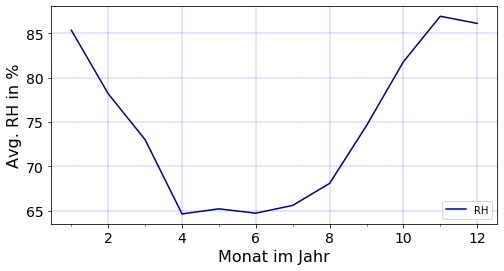

In [104]:
cdc_rh_df = pd.read_csv("ressources/dwd/data_MO_RF_MN004.csv")
cdc_rh_df.index = pd.to_datetime(cdc_rh_df["Zeitstempel"], format='%Y%m', errors='ignore')
plot_data = cdc_rh_df.groupby(test.index.month).mean()["Wert"]

fig, ax1 = plt.subplots(figsize=(8, 4))
ax1 = sns.lineplot(data=plot_data, color="navy", label="RH")
ax1.grid(color='b', linestyle='--', linewidth=0.3)
ax1.set_xlabel('Monat im Jahr', fontdict = {"size":16})
ax1.set_ylabel('Avg. RH in %', fontdict = {"size":16})
ax1.legend(loc='lower right')
ax1.set_xticks(plot_data.index, minor=True)
ax1.tick_params(axis='both', which='both', labelsize=14)
fig.savefig(graph_dir + "CDC_RH_Data.png", transparent=True, bbox_inches="tight",pad_inches=0.1, dpi=200)